# Семинар 13: Случайный лес

## 1. Bias-Variance decomposition

Вспомним, что функцию потерь в задачах регрессии или классификации можно разложить на три компоненты: смещение (bias), дисперсию (variance) и шум (noise). Эти компоненты позволяют описать сложность алгоритма, альтернативно сравнению ошибок на тренировочной и тестовой выборках. Хотя такое разложение можно построить для произвольной функции потерь, наиболее просто (и классически) оно строится для среднеквадратичной функции в задаче регрессии, что мы и рассмотрим ниже.

Пусть $(X, y)$ – некоторая выборка. Обучим интересующий нас алгоритм на этой выборке и сделаем предсказания на ней. Обозначим предсказания как $\hat{y}$. Тогда

$$
\mathrm{bias} := \mathbb{E}(\hat{y}) - y.
$$

$$
\mathrm{variance} := \mathbb{E}[\mathbb{E}(\hat{y}) - \hat{y}]^2
$$

$$
\mathrm{noise} := \mathbb{E}[y - \mathbb{E}(y)]^2
$$

Ожидаемую среднеквадратичную ошибку на тренировочной выборке можно разложить как

$$
\mathrm{E}[y - \hat{y}]^2 = \mathrm{bias}^2 + \mathrm{variance} + \mathrm{noise}.
$$

**Задание для самых смелых:** покажите, что это разложение корректно. Проверьте себя [здесь](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture08-ensembles.pdf).

**Техническое замечание:** все математические ожидания в разложении выше берутся по объектам тренировочной выборки, то есть это разложение верно для среднеквадратичной ошибки на тренировочной выборке, которую иногда называют MSE for estimator. Тем не менее, нам интересна и величина ошибки на ненаблюдаемых данных, которую иногда называют MSE for predictor. В этом случае математическое ожидание ошибки следует брать по ненаблюдаемым объектам. Для решения этой проблемы зачастую предполагается, что тренировочная и тестовая выборка имеют одинаковое распределение, и математическое ожидание берётся по всевозможным вариациям тренировочной выборки. Суть разложения при этом не изменится, однако запись его станет более громоздкой. Посмотреть на это можно [здесь](https://towardsdatascience.com/mse-and-bias-variance-decomposition-77449dd2ff55).

Заметим, что так как на практике мы считаем оценки математических ожиданий и зачастую имеем доступ к тестовой выборке, то проблем с расчётом **оценок** MSE for estimator и MSE for predictor не возникает.

Разберёмся с интерпретацией компонент:
- $\mathrm{Bias}$ — отклонение среднего ответа алгоритма от ответа идеального алгоритма. $\mathrm{Bias}$ отражает ошибку модели, возникающую из-за простоты модели. Высокое смещение обычно является показателем того, что модель недообучена.


- $\mathrm{Variance}$ — разброс ответов алгоритмов относительно среднего ответа алгоритма. Показывает, насколько сильно небольшие изменения в обучающей выборке скажутся на предсказаниях алгоритма. $\mathrm{Variance}$ отражает ошибку модели, возникающую из-за чрезмерной сложности модели. Высокая дисперсия обычно является показателем того, что модель переобучена.


- $\mathrm{Noise}$ — ошибка идеального классификатора, естественный неустранимый шум в данных.

Посмотрим наглядно на примере полиномиальной регрессии.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from tqdm.auto import trange

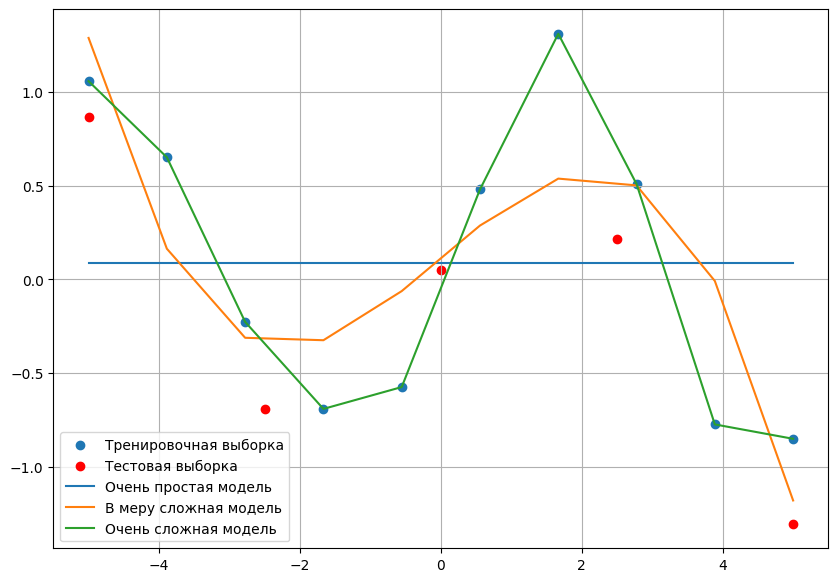

In [2]:
# Выборка
np.random.seed(42)
N = 10
X = np.linspace(-5, 5, N).reshape(-1, 1)
y = np.sin(X) + np.random.normal(0, 0.2, size=N).reshape(-1, 1)

X_test = np.linspace(-5, 5, N // 2).reshape(-1, 1)
y_test = np.sin(X_test) + np.random.normal(0, 0.2, size=N // 2).reshape(-1, 1)

# Очень простая модель (регрессия на константу)
too_simple_model_predictions = np.mean(y) * np.ones_like(y)

# В меру сложная модель
X_ok = np.hstack([X, X**2, X**3])
ok_model = LinearRegression()
ok_model.fit(X_ok, y)
ok_model_predictions = ok_model.predict(X_ok)

# Очень сложная модель
X_compl = np.hstack(
    [X, X**2, X**3, X**4, X**5, X**6, X**7, X**8, X**9, X**10]
)
compl_model = LinearRegression()
compl_model.fit(X_compl, y)
compl_model_predictions = compl_model.predict(X_compl)

plt.figure(figsize=(10, 7))

plt.scatter(X, y, label="Тренировочная выборка")
plt.scatter(X_test, y_test, c="r", label="Тестовая выборка")
plt.plot(X, too_simple_model_predictions, label="Очень простая модель")
plt.plot(X, ok_model_predictions, label="В меру сложная модель")
plt.plot(X, compl_model_predictions, label="Очень сложная модель")
plt.grid()
plt.legend();

- Очень простая модель имеет большое смещение (bias), но малую (нулевую) дисперсию (variance). Модель явно недообучена.

- В меру сложная модель имеет небольшое смещение (bias) и небольшую дисперсию (variance).

- Очень сложная модель имеет небольшое смещение (bias), но большую дисперсию (variance). Модель явно переобучена.

**Задание:** пользуясь определениями выше, объясните, почему это так.

**Задание:** прокомментируйте величину смещения и дисперсии для следующих моделей:

1. Линейная регрессия, обучаемая на большой выборке без выбросов и линейно зависимых признаков, в которой признаки сильно коррелируют с целевой переменной.
2. Решающее дерево, которое строится до тех пор, пока в листах не окажется по одному объекту.
3. Логистическая регрессия, относящая все точки к одному классу.

### Bias-Variance tradeoff

Из описания выше можно заметить, что при обучении моделей возникает выбор между смещением и дисперсией: недообученная модель имеет низкую дисперсию, но высокое смещение, а переобученная — низкое смещение, но высокую дисперсию. Этот выбор можно отобразить на картинке ([источник](https://www.bradyneal.com/bias-variance-tradeoff-textbooks-update)). Здесь Total Error – ошибка на тестовой выборке (generalization error).

![](https://www.bradyneal.com/img/bias-variance/fortmann-roe-bias-variance.png)

Вывод из неё очевиден: строить следует оптимальные по сложности модели.

Возникает ли такой выбор при обучении любой модели? Последние исследования показывают, что поведение ошибки при обучении некоторых (современных) моделей не соответствует такой U-образной форме. Например, было показано, что ошибка на тестовой выборке продолжает убывать при расширении (увеличении числа слоёв) нейронных сетей:

<img src="https://www.bradyneal.com/img/bias-variance/neyshabur.jpg" alt="drawing" width="400"/>

В таких моделях поведение ошибки приобретает сложный вид:


<img src="https://www.bradyneal.com/img/bias-variance/double_descent.jpg" alt="drawing" width="800"/>

## 2. От деревьев к случайному лесу

## 2.1 Решающее дерево

Мотивацию построения алгоритма случайного леса (Random Forest) удобно рассматривать в терминах смещения и дисперсии. Начнём с построения решающего дерева.

In [3]:
# Пример адаптирован отсюда: http://rasbt.github.io/mlxtend/user_guide/evaluate/bias_variance_decomp/
california = fetch_california_housing()
california_X = pd.DataFrame(data=california.data, columns=california.feature_names)
california_Y = california.target
print(f"X shape: {california_X.shape}, Y shape: {california_Y.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    california_X, california_Y, test_size=0.3, random_state=123, shuffle=True
)

X shape: (20640, 8), Y shape: (20640,)


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# TODO: обучите решающее дерево без ограничений на тренировочной выборке

# TODO: рассчитайте MSE на тренировочной и тестовой выборках

In [5]:
from mlxtend.evaluate import bias_variance_decomp

# TODO: воспользуйтесь функцией bias_variance_decomp и выведите среднее смещение и среднюю дисперсию модели
# на тестовой выборке

Как мы обсуждали на предыдущем семинаре, такое дерево окажется сильно переобученным (высокая дисперсия и низкое смещение). Постараемся исправить это. На лекции мы обсуждали, что один из способов борьбы с переобучением – построение композиций моделей. На этом семинаре мы рассмотрим построение композиций при помощи бэггинга.

### 2.2 Бэггинг

Вспомним суть алгоритма:

1. Обучаем много деревьев на бутстрапированных подвыборках исходной выборки независимо друг от друга. Бутстрапированную подвыборку строим при помощи выбора $N$ (размер исходной выборки) наблюдений из исходной выборки с возвращением. 

2. Усредняем предсказания всех моделей (например, берём арифметическое среднее). 

Можно показать, что модель, построенная при помощи бэггинга, будет иметь **то же смещение**, что и у отдельных деревьев, но значительно **меньшую дисперсию** (при выполнении некоторых условий). 

In [6]:
from sklearn.ensemble import BaggingRegressor

base_tree = DecisionTreeRegressor(random_state=123)

# TODO: обучите бэггинг с 20 деревьями, каждое из которых строится без ограничений

# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке

Как мы видим, по сравнению с единичным деревом смещение практически не изменилось, но дисперсия уменьшилась в несколько раз!

Посмотрим, как это отразилось на среднеквадратичной ошибке.

In [7]:
# TODO: рассчитайте MSE на тренировочной и тестовой выборках для бэггинга

Среднеквадратичная ошибка на тренировочной выборке больше не равна 0, а на тестовой – уменьшилась, что говорит о том, что мы успешно победили переобучение единичного решающего дерева. 

Можем ли мы снизить переобучение ещё сильнее? Можем!

### 2.3 Случайный лес

При построении каждого дерева в бэггинге в ходе создания очередного узла будем выбирать случайный набор признаков, на основе которых производится разбиение. В результате такой процедуры мы уменьшим корреляцию между деревьями, за счёт чего снизим дисперсию итоговой модели. Такой алгоритм назвывается **случайным лесом** (Random Forest).

По сравнению с единичным деревом к параметрам случайного леса добавляются:
- `max_features` – число признаков, на основе которых проводятся разбиения при построении дерева.

- `n_estimators` – число деревьев.

Естественно, все параметры, относящиеся к единичному дереву, сохраняются для случайного леса.

In [8]:
from sklearn.ensemble import RandomForestRegressor

# TODO: обучите случайный лес с 20 деревьями, каждое из которых строится без ограничений

# TODO: выведите среднее смещение и среднюю дисперсию модели на тестовой выборке

# TODO: рассчитайте MSE на тренировочной и тестовой выборках для случайного леса

Как мы видим, по сравнению с бэггингом смещение вновь осталось практически неизменным, а дисперсия немного уменьшилась. Конечно, если подобрать хорошие гиперпараметры, то получится снизить дисперсию ещё больше. 

Ошибка на тренировочной выборке увеличилась, а на тестовой – уменьшилась, что означает, что мы добились нашей цели в борьбе с переобученными деревьями!

## 3. Особенности случайного леса

### 3.1 Число деревьев и "Случайный лес не переобучается"

В своём [блоге](https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks) Лео Бриман (Leo Breiman), создатель случайного леса, написал следующее:

> Random forest does not overfit. You can run as many trees as you want.

**Обратите внимание:** как говорилось на лекции, случайный лес не переобучается именно с ростом числа деревьев (за счёт совместной работы бэггинга и использования случайных подпространств), но не в принципе. Посмотрим на поведение случайного леса при росте числа деревьев.

  0%|          | 0/50 [00:00<?, ?it/s]

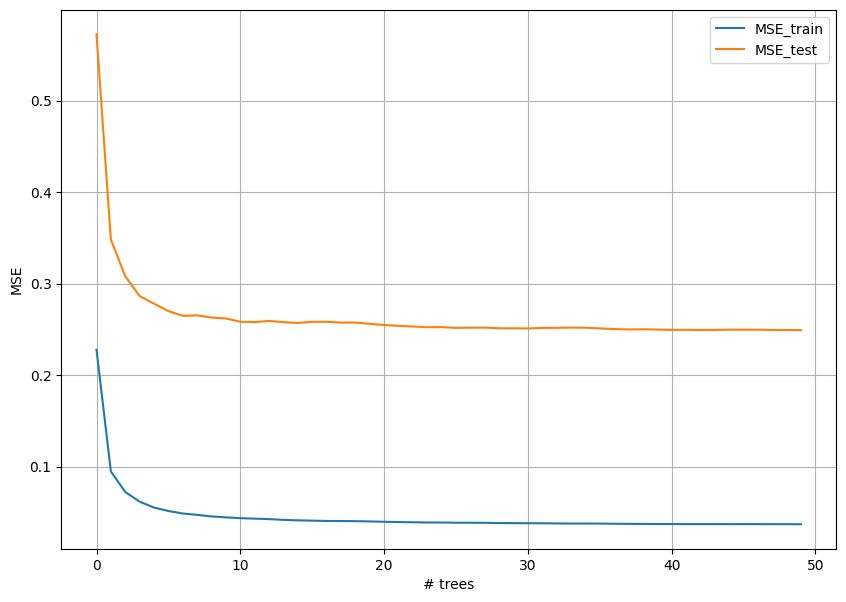

In [10]:
n_trees = 100
train_loss = []
test_loss = []

for i in trange(1, n_trees, 2):
    rf = RandomForestRegressor(n_estimators=i, random_state=123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(train_loss, label="MSE_train")
plt.plot(test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("# trees")
plt.legend();

Как и ожидалось, по достижении некоторого числа деревьев обе ошибки практически не изменяются, то есть переобучения при росте числа деревьев не происходит.

Однако практика показывает, что при изменении какого-нибудь другого параметра на реальных данных переобучение может произойти: [пример 1](https://datascience.stackexchange.com/questions/1028/do-random-forest-overfit), [пример 2](https://mljar.com/blog/random-forest-overfitting/). Например, случайный лес с ограниченными по глубине деревьями может предсказывать более точно, чем лес без ограничений. 

В нашем же случае случайный лес, скорее, лишь страдает от регуляризации. Например, посмотрим на поведение модели при изменении максимальной глубины деревьев (поэксперементируйте с другими параметрами).

  0%|          | 0/25 [00:00<?, ?it/s]

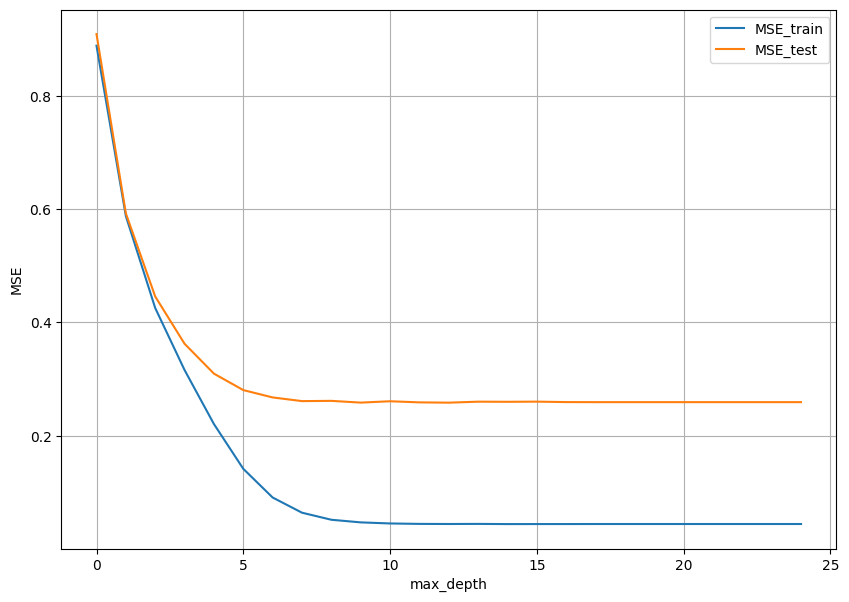

In [11]:
max_depth = 50
train_loss = []
test_loss = []

for i in trange(1, max_depth, 2):
    rf = RandomForestRegressor(n_estimators=20, max_depth=i, random_state=123)
    rf.fit(X_train, y_train)
    train_loss.append(mean_squared_error(y_train, rf.predict(X_train)))
    test_loss.append(mean_squared_error(y_test, rf.predict(X_test)))

plt.figure(figsize=(10, 7))
plt.grid()
plt.plot(train_loss, label="MSE_train")
plt.plot(test_loss, label="MSE_test")
plt.ylabel("MSE")
plt.xlabel("max_depth")
plt.legend();

Переобучение не наблюдается. Вообще же, как обычно, гиперпараметры случайного леса стоит подбирать на кросс-валидации.

#### 4.2 Out-of-bag-ошибка

Как мы обсудили выше, при построении случайного леса каждое дерево строится на бутстрапированной подвыборке, полученной из исходной обучающей выборки случайным набором с повторениями. Понятно, что некоторые наблюдения попадут в такую подвыборку несколько раз, а некоторые не войдут в неё вообще. Для каждого дерева мы можем рассмотреть объекты, которые не участвовали в обучении и использовать их для валидации.

Усреднённая ошибка на неотобранных образцах по всему случайному лесу называется **out-of-bag-ошибкой**.

In [12]:
# oob_score_ = R2 на невиденных наблюдениях
rf = RandomForestRegressor(n_estimators=100, random_state=123, oob_score=True)
rf.fit(X_train, y_train)
rf.oob_score_

0.800305147049665

#### 4.3 Важность признаков

Как и решающие деревья, случайный лес позволяет оценивать важность признаков.

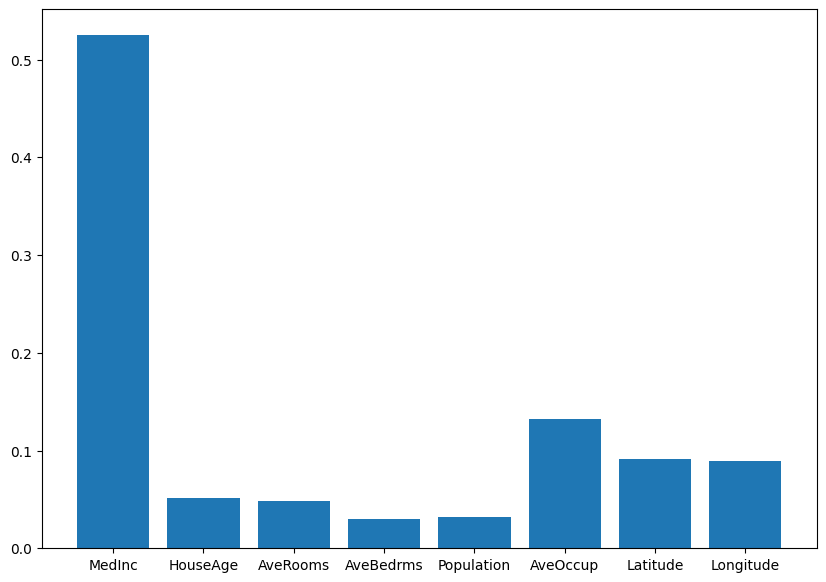

In [14]:
plt.figure(figsize=(10, 7))
plt.bar(california["feature_names"], rf.feature_importances_);

Будьте осторожны с сильно коррелирующими признаками. Посмотрим, что произойдёт с важностью, если добавить в выборку линейно зависимый признак.

In [15]:
RM_mc = np.array((X_train.iloc[:, 5] * 2 + 3)).reshape(-1, 1)
X_train_new = np.hstack((X_train, RM_mc))

In [16]:
rf.fit(X_train_new, y_train)

RandomForestRegressor(oob_score=True, random_state=123)

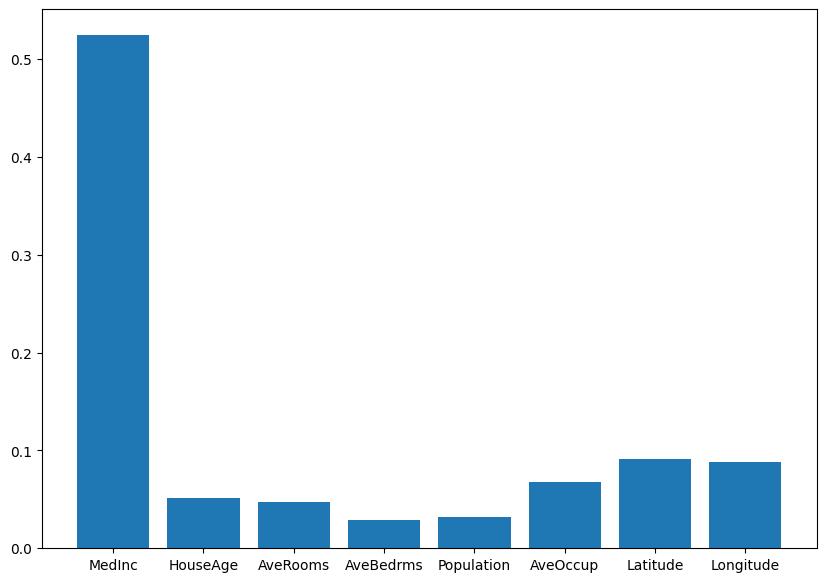

In [17]:
plt.figure(figsize=(10, 7))
names = list(california["feature_names"])
names.append("AveOccup")
plt.bar(names, rf.feature_importances_);

Важности перераспределились между линейной зависимыми признаками `AveOccup` и `AveOccup_mc`. Не забывайте учитывать корреляции между признаками, если вы используете этот метод для отбора признаков. Также обратите внимание на предупреждение в документации `sklearn`: не стоит использовать этот метод и для признаков, в которых есть много уникальных значений (например, категориальные признаки с небольшим числом категорий). 

## 4. Тестирование случайного леса на разных данных

Ниже представлены шаблоны для сравнения случайного леса и других моделей на данных разных типов. Проведите побольше экспериментов, используя разные модели и метрики. Попробуйте подобрать гиперпараметры случайного леса так, чтобы достичь какого-нибудь порога качества. 

**Внимание:** в этой части вам предстоит скачивать объёмные наборы данных. Не забудьте удалить их после семинара, если не планируете использовать их в дальнейшем, чтобы они не занимали лишнее место на вашем компьютере.

**! Случайный лес может обучаться достаточно долго.**

### 4.1 Бинарная классификация на примере [Kaggle Predicting a Biological Response](https://www.kaggle.com/c/bioresponse/data?select=train.csv)

In [18]:
# Загрузка данных
# !wget  -O 'kaggle_response.csv' -q 'https://www.dropbox.com/s/uha70sej5ugcrur/_train_sem09.csv?dl=1'

In [19]:
data = pd.read_csv("kaggle_response.csv")
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# TODO: обучите логистическую регрессию и случайный лес с дефолтными параметрами
# Сравните их AUC ROC на тестовой выборке

### 4.2 Изображения на примере [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)

In [21]:
import torchvision

fmnist = torchvision.datasets.FashionMNIST("./", download=True)
X, y = fmnist.data.numpy().reshape(-1, 28 * 28), fmnist.targets.numpy()

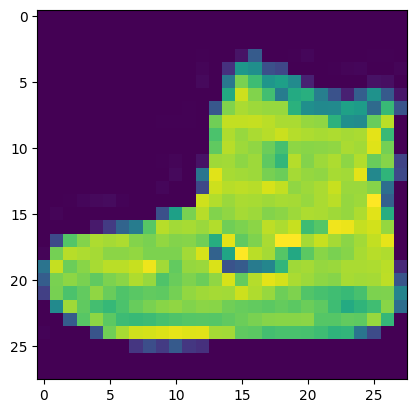

In [22]:
plt.imshow(X[0, :].reshape(28, 28));

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

# TODO: обучите случайный лес и kNN с дефолтными параметрами
# Сравните их доли правильных ответов на тестовой выборке